In [239]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

import pickle

TRAIN_NEW_MODEL = False
NEW_MODEL_TRAIN_COUNT = 2000

In [240]:
# Read csv and output feature columns.
df = pd.read_csv('fortune_500.csv')
df.columns

Index(['Rank', 'Title', 'Website', 'Employees', 'Sector', 'Industry',
       'Hqlocation', 'Hqaddr', 'Hqcity', 'Hqstate', 'Hqzip', 'Hqtel', 'Ceo',
       'Ceo-title', 'Address', 'Ticker', 'Fullname', 'Revenues', 'Revchange',
       'Profits', 'Prftchange', 'Assets', 'Totshequity'],
      dtype='object')

In [241]:
# Remove all empty rows and get information about the data types in the df.
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         500 non-null    int64  
 1   Title        500 non-null    object 
 2   Website      500 non-null    object 
 3   Employees    500 non-null    int64  
 4   Sector       500 non-null    object 
 5   Industry     500 non-null    object 
 6   Hqlocation   500 non-null    object 
 7   Hqaddr       500 non-null    object 
 8   Hqcity       500 non-null    object 
 9   Hqstate      500 non-null    object 
 10  Hqzip        500 non-null    int64  
 11  Hqtel        500 non-null    object 
 12  Ceo          500 non-null    object 
 13  Ceo-title    500 non-null    object 
 14  Address      500 non-null    object 
 15  Ticker       500 non-null    object 
 16  Fullname     500 non-null    object 
 17  Revenues     500 non-null    int64  
 18  Revchange    500 non-null    float64
 19  Profits 

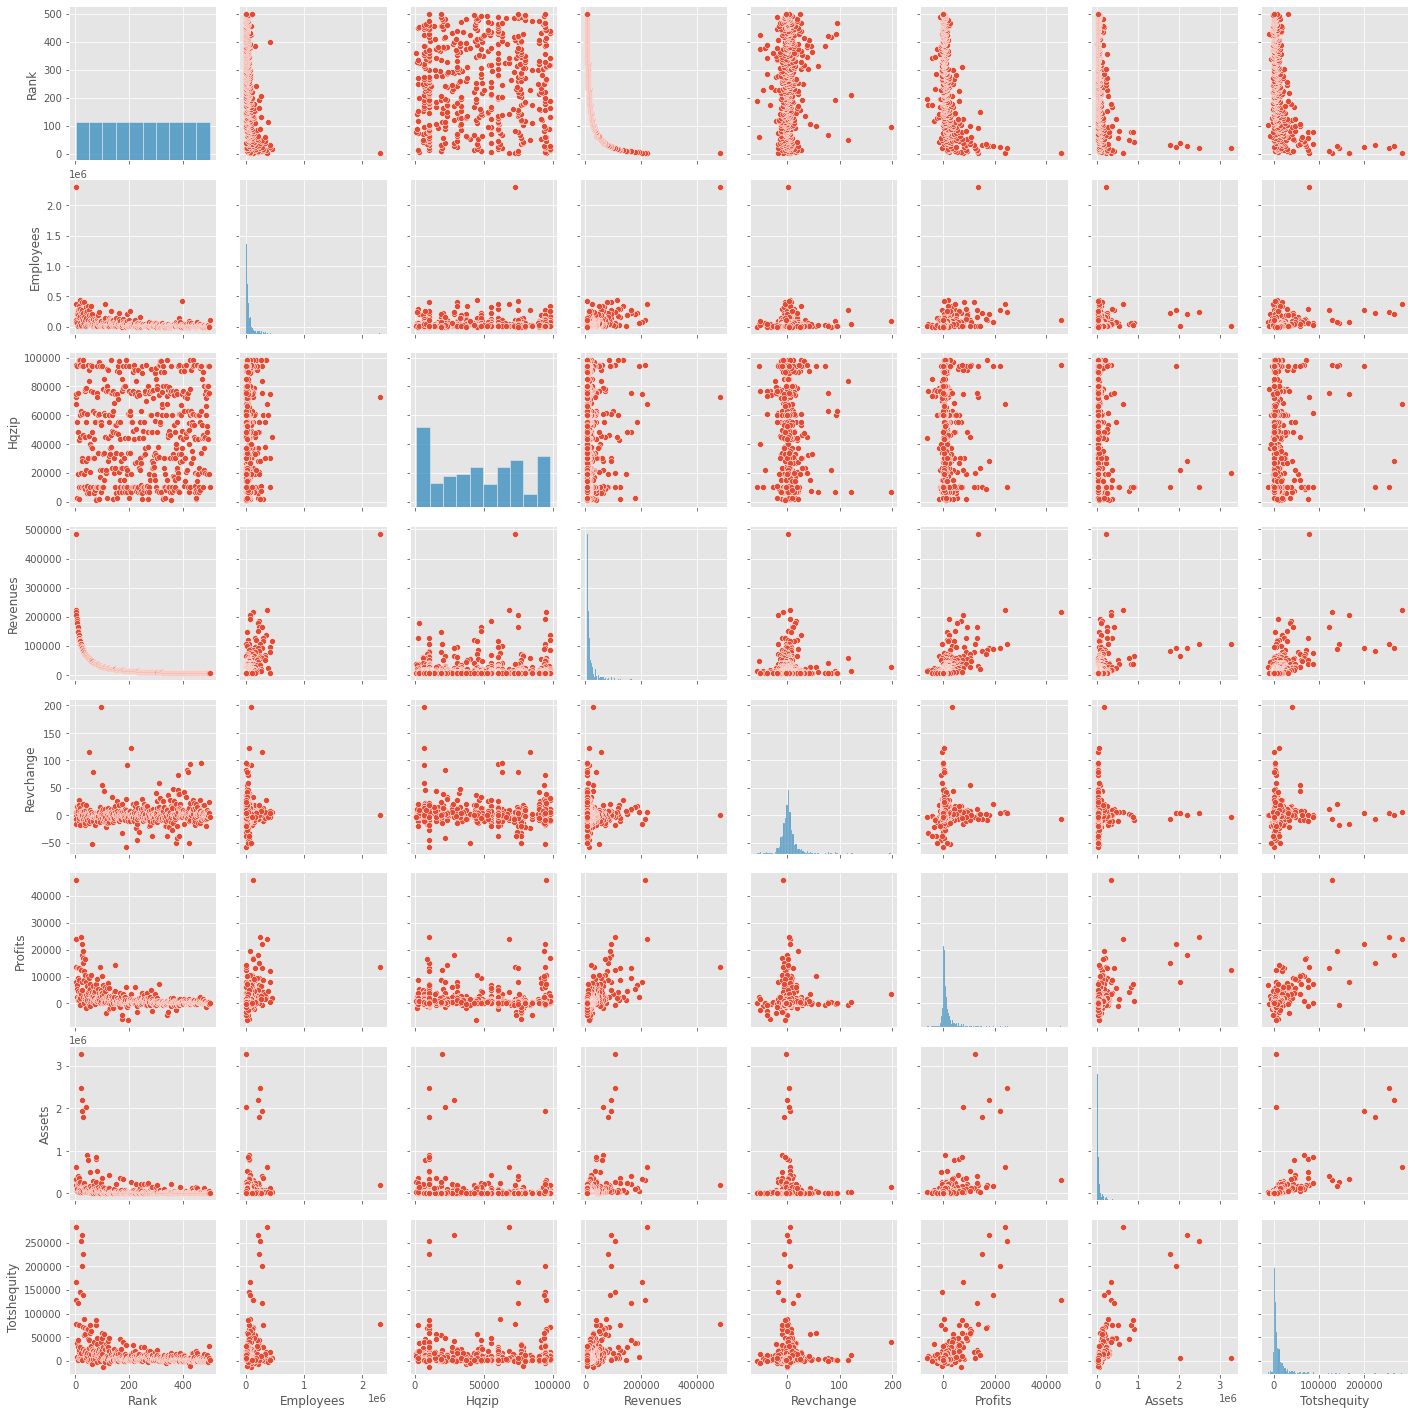

In [253]:
# Understand different relationship between different variables with seaborn.
sns.pairplot(df)

In [243]:
x = df[['Profits', 'Employees', 'Assets', 'Totshequity']]  # Variables used to make predictions
y = df['Revenues']  # Variables we are going to predict
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

def train_new_model():
    """
    Train new model by attempting to create the best model in a certain
    amount of tries - NEW_MODEL_TRAIN_COUNT.
    Save the best model as a pickle file.
    """
    best_lin_reg = 0
    best_lasso_reg = 0
    for _ in range(NEW_MODEL_TRAIN_COUNT):

        # Split data into training and testing.
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

        # Apply linear regression model.
        RidgeReg = Ridge(normalize=True)
        RidgeReg.fit(x_train, y_train)

        # Calculate accuracy and swap model if it's better than the current best.
        accuracy = RidgeReg.score(x_test, y_test)
        if accuracy > best_lin_reg:
            best_lin_reg = accuracy
            with open('fortune_500_lin_reg_model.pickle', 'wb') as f:
                pickle.dump(RidgeReg, f)

        # Similar approach for Lasso regression.
        LassoReg = Lasso(normalize=True)
        LassoReg.fit(x_train, y_train)
        accuracy = LassoReg.score(x_test, y_test)
        if accuracy > best_lasso_reg:
            best_lasso_reg = accuracy
            with open('fortune_500_lasso_reg_model.pickle', 'wb') as f:
                pickle.dump(LassoReg, f)

# Train new model if specified, otherwise populate it from the pickle file.
if TRAIN_NEW_MODEL:
    train_new_model()
pickle_in = open('fortune_500_ridge_reg_model.pickle', 'rb')
RidgeReg = pickle.load(pickle_in)
pickle_in = open('fortune_500_lasso_reg_model.pickle', 'rb')
LassoReg = pickle.load(pickle_in)

In [244]:
# Evaluate the model's coefficients.
print('Accuracy: ', RidgeReg.score(x_test, y_test))
pd.DataFrame(RidgeReg.coef_, x.columns, columns = ['Coeff'])

Accuracy:  0.7399977588328488


,Coeff
Profits,1.646756
Employees,0.109079
Assets,0.007437
Totshequity,0.173798


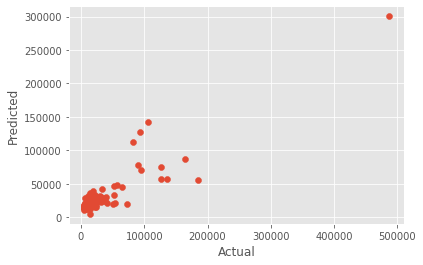

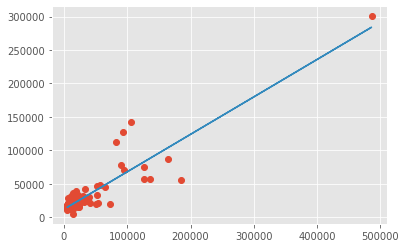

In [245]:
# Make predictions:
predictions = RidgeReg.predict(x_test)

# Produce scatter graph between y_test values and predictions.
style.use('ggplot')
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Draw line of best fit.
slope, y_intercept = np.polyfit(y_test, predictions, 1)
plt.plot(y_test, predictions, 'o')
plt.plot(y_test, slope*y_test + y_intercept)

(array([ 11., 118.,  12.,   4.,   1.,   2.,   0.,   1.,   0.,   1.]),
 array([-36568.73309647, -14367.13231265,   7834.46847118,  30036.06925501,
         52237.67003884,  74439.27082267,  96640.8716065 , 118842.47239033,
        141044.07317416, 163245.67395799, 185447.27474182]),
 <BarContainer object of 10 artists>)

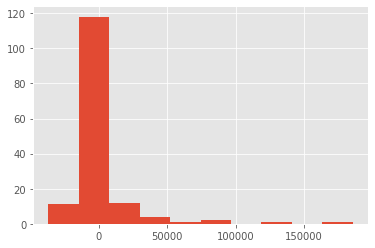

In [246]:
plt.hist(y_test - predictions)

In [247]:
def predict_individual(model, data, actual_revenue=None):
    """
    Predict an individual value given a model and data.
    :param actual_revenue: (optional) to show the accuracy of the prediction
    """
    prediction = model.predict([data])[0]
    print('Prediction: ', prediction)
    if actual_revenue:
        print('Accuracy: ', (prediction / actual_revenue if prediction < actual_revenue else actual_revenue / prediction)  * 100, '%')
    return prediction

# Predict: Core-Mark Holding
predict_individual(RidgeReg, [54.2, 7688, 1497, 530], actual_revenue=11507)

Prediction:  13107.55248459194
Accuracy:  87.78908200845729 %


C:\Dev\Tools\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


13107.55248459194

In [248]:
# The mean squared error of Ridge regression model.
print("Mean squared error: %.2f" % np.mean((RidgeReg.predict(x_test) - y_test) ** 2))

Mean squared error: 602800833.97


In [249]:
# Now apply the same approach to lasso regression in order to compare it against ridge regression.

# Evaluate the model's coefficients.
print('Accuracy: ', LassoReg.score(x_test, y_test))
pd.DataFrame(LassoReg.coef_, x.columns, columns = ['Coeff'])

Accuracy:  0.8596247289022234


,Coeff
Profits,2.121815
Employees,0.181435
Assets,-0.000384
Totshequity,0.269825


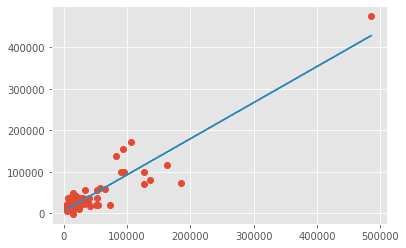

In [250]:
# Make predictions.
predictions = LassoReg.predict(x_test)

# Draw line of best fit.
slope, y_intercept = np.polyfit(y_test, predictions, 1)
plt.plot(y_test, predictions, 'o')
plt.plot(y_test, slope*y_test + y_intercept)

In [251]:
# Same individual prediction as RidgeReg.
# Predict: Core-Mark Holding
predict_individual(LassoReg, [54.2, 7688, 1497, 530], actual_revenue=11507)

Prediction:  8944.862062611342
Accuracy:  77.73409283576382 %


C:\Dev\Tools\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(


8944.862062611342

In [252]:
# The mean squared error of Lasso regression model.
print("Mean squared error: %.2f" % np.mean((LassoReg.predict(x_test) - y_test) ** 2))

Mean squared error: 325452311.90
